In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
#%pylab nbagg
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
%%capture

import numpy as np
import time as tm
import matplotlib.pyplot as plt        
import matplotlib.gridspec as gridspec 

#import sys
#import os
#import scipy.io as io
from math import pi
###############################################################################

#The Virtual Brain
#from tvb.simulator.lab import *       #doesn't work on cluster
import tvb
#import tvb.simulator.simulator as simulator
#import tvb.simulator.models as models
#import tvb.simulator.coupling as coupling
#import tvb.simulator.integrators as integrators
#import tvb.simulator.noise as noise
#import tvb.simulator.monitors as monitors
#import tvb.datatypes.connectivity as connectivity
from tvb.simulator.lab import *

#from thetanmm.model import Theta2D
#import thetanmm.model as models 

#Freq Decomposition
from scipy import signal
from scipy.signal import argrelextrema
from scipy.signal import butter, lfilter, freqz
#Clustering
from sklearn.cluster import KMeans
#PCA
from sklearn.decomposition import PCA

from scipy import stats
from scipy.sparse import rand
import networkx as nx

In [5]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

viridis = cm.get_cmap('viridis', 100)
print(viridis)

In [6]:
sys.path.insert(0, '/Users/giovanni/Documents/GitHub/fufo/')
from src import analysis, simulation, model_HH_ABH 

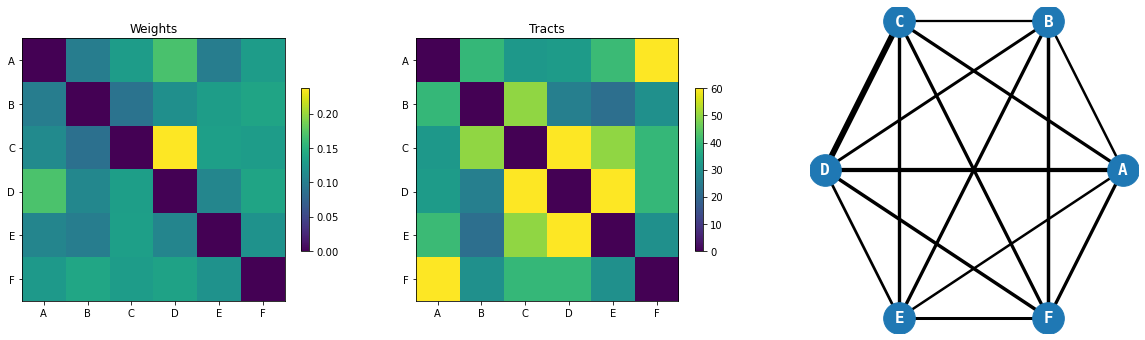

In [7]:
####################################################################
# IMPORT STRUCTURAL CONNECTIVITY
####################################################################
SC6_con = connectivity.Connectivity.from_file("/Users/giovanni/Desktop/Neuro/tvb_codes/connectivity/6x6full.zip")

nregions = len(SC6_con.weights)   
condspeed=np.infty #np.float(1.) #
SC6_con.speed = np.array([condspeed])
np.fill_diagonal(SC6_con.weights, 0.)
#np.fill_diagonal(SC6_con.tract_lengths, 0.)

#normalization
SC6_con.configure()

SC6 = SC6_con.weights
SC6_con.tract_lengths=SC6_con.tract_lengths
SC6_tracts = SC6_con.tract_lengths
SC6_labels = ['A','B','C','D','E','F']

plt.figure(figsize=(20,6))
plt.subplot(131)
plt.imshow(SC6);plt.xticks(np.arange(6),SC6_labels);plt.yticks(np.arange(6),SC6_labels);plt.title('Weights');plt.colorbar(shrink=0.5)
plt.subplot(132)
plt.imshow(SC6_tracts);plt.xticks(np.arange(6),SC6_labels);plt.yticks(np.arange(6),SC6_labels);plt.title('Tracts');plt.colorbar(shrink=0.5)
plt.subplot(133)
G=nx.from_numpy_matrix(SC6_tracts)
def listToDict(lst):
    op = { i : lst[i] for i in range(0, len(lst) ) }
    return op
lab=listToDict(SC6_labels)
weights = 25*SC6[np.triu_indices(len(SC6),1)]
nx.draw_circular(G,labels=lab, width=weights, node_size=1000,font_color='w',font_size=16,font_weight='bold',font_family='monospace')

In [8]:
viridis= cm.get_cmap('viridis', 10)

In [9]:
cln=[viridis(3),viridis(2),viridis(7),viridis(8),viridis(4),viridis(1)]

# CONFIGURE

In [10]:
# 'E', 'K_bath', 'J', 'eta', 'Delta', 'G','c_minus','R_minus','c_plus','R_plus','Vstar'
E = 0
K_bath = 15.5
J=0.08
eta=0
Delta=1
R_minus=0.02
R_plus=-0.1
c_minus=-44.24
c_plus=-20.4
Vstar = -31

In [21]:
## Initialise Integrator
dt = .1
heunint = integrators.RungeKutta4thOrderDeterministic(dt=dt)
cut_in=0
simlen=20e3+cut_in
x_0=np.random.uniform(low=0.1, high=0.1, size=((1,1,nregions,1)))
V_0=np.random.uniform(low=-15., high=-15., size=((1,1,nregions,1)))
n_0=np.random.uniform(low=0.45, high=0.45, size=((1,1,nregions,1)))
DKi_0=np.random.uniform(low=-5, high=-5, size=((1,1,nregions,1)))
Kg_0=np.random.uniform(low=-16., high=-16., size=((1,1,nregions,1)))
init_cond=np.concatenate([x_0, V_0, n_0, DKi_0, Kg_0], axis=1)

# Healthy

In [22]:
G=0.
THH = model_HH_ABH.InfiniteHH(
            E = np.r_[E],
            K_bath = np.asarray([5.5,5.5,5.5,K_bath,5.5,5.5]),#np.r_[K_bath],#
            J = np.r_[J],
            eta = np.r_[eta],
            Delta = np.r_[Delta],
            c_minus = np.r_[c_minus],
            R_minus = np.r_[R_minus],
            c_plus = np.r_[c_plus],
            R_plus = np.r_[R_plus],
            Vstar = np.r_[Vstar])


# Initialise some Monitors with period in physical time.
#mon_tavg = monitors.TemporalAverage(period=Tperiod)
mon_raw = monitors.Raw()
what_to_watch = (mon_raw, ) #(mon_tavg, mon_bold) 

# Initialise Coupling
con_coupling = coupling.Scaling(a=np.array([G]))

# Initialise the Simulator.
sim = simulator.Simulator(model=THH,
                          connectivity=SC6_con,
                          conduction_speed=condspeed,
                          coupling=con_coupling,
                          integrator=heunint,
                          monitors= what_to_watch,
                          simulation_length=simlen) 
sim.initial_conditions = init_cond    
sim.configure()

,value
Type,Simulator
conduction_speed,inf
connectivity,Connectivity gid: 5ce33e6c-535d-4b8f-8755-37dcff2e2516
coupling,Scaling gid: 2972cd34-3bb3-478f-a531-c41f904ed2d5
gid,UUID('2c8cd4c9-49cb-45a2-a717-b9e2f210339a')
"initial_conditions [min, median, max]","[-16, -5, 0.45]"
initial_conditions dtype,float64
initial_conditions shape,"(1, 5, 6, 1)"
integrator,RungeKutta4thOrderDeterministic gid: 0a60c2fd-3399-4f06-a93b-482624eb3b6c
model,InfiniteHH gid: 525e7fd1-80b4-427e-99a8-339d8c9e8a17


In [23]:
G=0.
THH = model_HH_ABH.InfiniteHH(
            E = np.r_[E],
            K_bath = np.r_[5.5,5.5,5.5,K_bath,5.5,5.5],#np.r_[K_bath],#
            J = np.r_[J],
            eta = np.r_[eta],
            Delta = np.r_[Delta],
            c_minus = np.r_[c_minus],
            R_minus = np.r_[R_minus],
            c_plus = np.r_[c_plus],
            R_plus = np.r_[R_plus],
            Vstar = np.r_[Vstar])


# Initialise some Monitors with period in physical time.
#mon_tavg = monitors.TemporalAverage(period=Tperiod)
mon_raw = monitors.Raw()
what_to_watch = (mon_raw, ) #(mon_tavg, mon_bold) 

# Initialise Coupling
con_coupling = coupling.Scaling(a=np.array([G]))

# Initialise the Simulator.
sim = simulator.Simulator(model=THH,
                          connectivity=SC6_con,
                          conduction_speed=condspeed,
                          coupling=con_coupling,
                          integrator=heunint,
                          monitors= what_to_watch,
                          simulation_length=simlen) 
sim.initial_conditions = init_cond    
sim.configure()

,value
Type,Simulator
conduction_speed,inf
connectivity,Connectivity gid: 5ce33e6c-535d-4b8f-8755-37dcff2e2516
coupling,Scaling gid: c13d2ef0-8651-4c06-82e7-f73f2107f2bf
gid,UUID('99e77ada-50d8-47ed-9b78-ce3f2428c78e')
"initial_conditions [min, median, max]","[-16, -5, 0.45]"
initial_conditions dtype,float64
initial_conditions shape,"(1, 5, 6, 1)"
integrator,RungeKutta4thOrderDeterministic gid: 0a60c2fd-3399-4f06-a93b-482624eb3b6c
model,InfiniteHH gid: e30504cd-ce52-4ffb-9a56-1cc99a5a8fd1


In [24]:
####################################################################
# RUN the SIMULATION 
####################################################################
#(raw_time, raw_data), (tavg_time, tavg_data) = sim.run()
(raw_time, raw_data),  = sim.run()

In [25]:
# Make the lists numpy.arrays for easier use.    
#TAVG=np.squeeze(np.array(tavg_data))   
RAW_h=np.squeeze(np.array(raw_data))   

R_h=(1000*R_minus/np.pi)*RAW_h[:,0,:]
V_h=RAW_h[:,1,:]

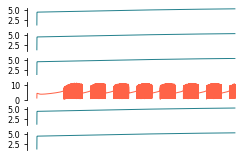

In [48]:
fig, ax = plt.subplots(nrows=6,ncols=1,figsize=(3.3,2.))
for i in range(6):
    ax[i].plot(R_h[:,i],c=cln[i],linewidth=1)
    ax[i].spines["top"].set_visible(False)
    ax[i].spines["right"].set_visible(False)
    ax[i].spines["bottom"].set_visible(False)
    ax[i].set_xticks([])#np.asarray([0,7000]),np.asarray([0,70]))
    ax[i].tick_params(labelsize=8)
    #ax[i].set_ylim(-100,-10)

plt.tight_layout(pad=0)
path='/Users/giovanni/Documents/GitHub/fufo/data/Interim/Abhirup/Figures/Fig6/'
plt.savefig(path+'Fig6_SimulatedTS_healthy.pdf',dpi=300,transparent=True)
plt.show()

# Pathological 

In [33]:
K_bath

15.5

In [42]:
G = 100.
THH = model_HH_ABH.InfiniteHH(
            E = np.r_[E],
            K_bath = np.asarray([5.5,5.5,5.5,K_bath,5.5,5.5]),
            J = np.r_[J],
            eta = np.r_[eta],
            Delta = np.r_[Delta],
            c_minus = np.r_[c_minus],
            R_minus = np.r_[R_minus],
            c_plus = np.r_[c_plus],
            R_plus = np.r_[R_plus],
            Vstar = np.r_[Vstar])


# Initialise some Monitors with period in physical time.
#mon_tavg = monitors.TemporalAverage(period=Tperiod)
mon_raw = monitors.Raw()
what_to_watch = (mon_raw, ) #(mon_tavg, mon_bold) 

# Initialise Coupling
con_coupling = coupling.Scaling(a=np.array([G]))

# Initialise the Simulator.
sim = simulator.Simulator(model=THH,
                          connectivity=SC6_con,
                          conduction_speed=condspeed,
                          coupling=con_coupling,
                          integrator=heunint,
                          monitors= what_to_watch,
                          simulation_length=simlen) 
sim.initial_conditions = init_cond    
sim.configure()

,value
Type,Simulator
conduction_speed,inf
connectivity,Connectivity gid: 5ce33e6c-535d-4b8f-8755-37dcff2e2516
coupling,Scaling gid: 98a8e723-84d7-4d44-b554-2bb01f953192
gid,UUID('2df49e0c-5a3b-4a41-8c39-54c8a3d53002')
"initial_conditions [min, median, max]","[-16, -5, 0.45]"
initial_conditions dtype,float64
initial_conditions shape,"(1, 5, 6, 1)"
integrator,RungeKutta4thOrderDeterministic gid: 0a60c2fd-3399-4f06-a93b-482624eb3b6c
model,InfiniteHH gid: 093a73f5-3dc0-4d67-a0b2-b117af036d0b


In [43]:
####################################################################
# RUN the SIMULATION 
####################################################################
#(raw_time, raw_data), (tavg_time, tavg_data) = sim.run()
(raw_time, raw_data),  = sim.run()

In [44]:
# Make the lists numpy.arrays for easier use.    
#TAVG=np.squeeze(np.array(tavg_data))   
RAW_p=np.squeeze(np.array(raw_data))   

R_p=(1000*R_minus/np.pi)*RAW_p[:,0,:]
V_p=RAW_p[:,1,:]

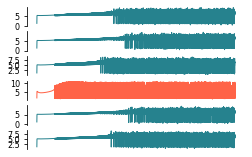

In [49]:
fig, ax = plt.subplots(nrows=6,ncols=1,figsize=(3.3,2.))
for i in range(6):
    ax[i].plot(R_p[:,i],c=cln[i],linewidth=1)
    ax[i].spines["top"].set_visible(False)
    ax[i].spines["right"].set_visible(False)
    ax[i].spines["bottom"].set_visible(False)
    ax[i].set_xticks([])#np.asarray([0,7000]),np.asarray([0,70]))
    ax[i].tick_params(labelsize=8)
    #ax[i].set_ylim(-100,-10)

plt.tight_layout(pad=0)
path='/Users/giovanni/Documents/GitHub/fufo/data/Interim/Abhirup/Figures/Fig6/'
plt.savefig(path+'Fig6_SimulatedTS.pdf',dpi=300,transparent=True)
plt.show()

In [63]:
THH = model_HH_ABH.InfiniteHH(
            E = np.r_[E],
            K_bath = np.asarray([K_bath,K_bath,K_bath,15.5,K_bath,K_bath]),
            J = np.r_[J],
            eta = np.r_[eta],
            Delta = np.r_[Delta],
            c_minus = np.r_[c_minus],
            R_minus = np.r_[R_minus],
            c_plus = np.r_[c_plus],
            R_plus = np.r_[R_plus],
            Vstar = np.r_[Vstar],
            G = np.r_[0])

In [22]:
# Initialise some Monitors with period in physical time.
#mon_tavg = monitors.TemporalAverage(period=Tperiod)
mon_raw = monitors.Raw()
what_to_watch = (mon_raw, ) #(mon_tavg, mon_bold) 

# Initialise Coupling
con_coupling = coupling.Scaling(a=np.array([G]))

# Initialise the Simulator.
sim = simulator.Simulator(model=THH,
                          connectivity=SC6_con,
                          conduction_speed=1.,
                          coupling=con_coupling,
                          integrator=heunint,
                          monitors= what_to_watch,
                          simulation_length=simlen) 
sim.initial_conditions = init_cond    
sim.configure()

,value
Type,Simulator
conduction_speed,1.0
connectivity,Connectivity gid: 343cd2fe-6018-4cd1-9a60-49e55f7dab09
coupling,Scaling gid: ce83b73f-a0ec-4a6c-951a-02c4e46e713f
gid,UUID('8f3cee95-7b2d-4716-b6e1-d4670177e7cd')
"initial_conditions [min, median, max]","[-16.4893, -5.13054, 0.47425]"
initial_conditions dtype,float64
initial_conditions shape,"(1, 5, 6, 1)"
integrator,HeunDeterministic gid: 53855f22-3b1e-44ce-b3d4-da369f2b83af
model,InfiniteHH gid: ad0a8e54-adf5-4c8d-8d53-7507c5081377


In [199]:

####################################################################
# RUN the SIMULATION 
####################################################################
#(raw_time, raw_data), (tavg_time, tavg_data) = sim.run()
(raw_time, raw_data),  = sim.run()

In [200]:
# Make the lists numpy.arrays for easier use.    
#TAVG=np.squeeze(np.array(tavg_data))   
RAW_h=np.squeeze(np.array(raw_data))   

R_h=(1000*R_minus/np.pi)*RAW_h[:,0,:]
V_h=RAW_h[:,1,:]

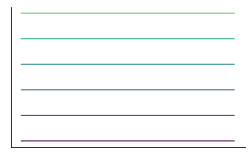

In [203]:
fig, ax = plt.subplots(figsize=(3.6,2.3))
for i in range(6):
    ax.plot(1200*i+R_h[190000:,i],c=viridis(15*i),linewidth=1)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])
#ax.set_yticks([-75,-50,-25,0,25],['','','','',''])
plt.tight_layout()
#plt.savefig('VPop75.pdf',dpi=300)
plt.show()

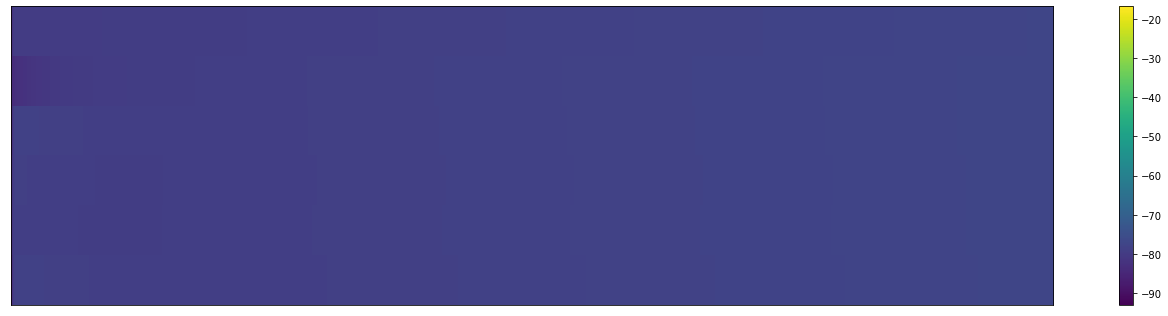

In [204]:
plt.figure(figsize=(18.45,4.5))
#plt.figure(figsize=(2.1,1.35))
plt.imshow(V_h.T,cmap='viridis',interpolation='nearest',aspect='auto')
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.tight_layout()
#plt.savefig(pathfig+'Fig2/DCmat_s.pdf', transparent=True, format="PDF")
plt.show()

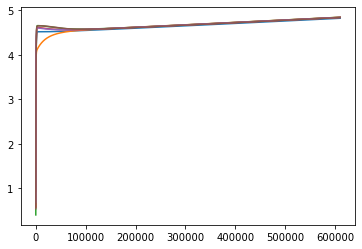

In [356]:
# heterogeneous init_cond, homogeneous Kbath=5.5, G=10
plt.plot(R_h)

In [ ]:
meanr/x=1000/100

In [45]:
viridis_range=[0,99]

In [184]:
Mean_R_p=np.mean(R_p[-100000:],axis=0)

In [185]:
node_siz_p*4000

array([3186.03225853, 3124.72692387, 3676.01468425, 4000.        ,
       3174.4108395 , 3010.81042122])

In [189]:
500+Mean_R_p*20

array([ 665.62535237,  631.18060346, 1421.8317059 , 3040.06415973,
        658.51938983,  584.00898114])

In [176]:
node_siz_p=(Mean_R_p/np.max(Mean_R_p))**(1/12)

In [165]:
lab={0: '5.5', 1: '5.5', 2: '5.5', 3: '15.5', 4: '5.5', 5: '5.5'}

# PLOT RESULT

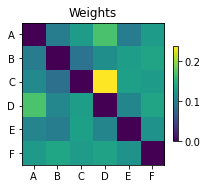

In [71]:
plt.figure(figsize=(3,3))
plt.imshow(SC6);plt.xticks(np.arange(6),SC6_labels);plt.yticks(np.arange(6),SC6_labels);plt.title('Weights');plt.colorbar(shrink=0.5)
plt.tight_layout()
path='/Users/giovanni/Documents/GitHub/fufo/data/Interim/Abhirup/Figures/Fig6/'
plt.savefig(path+'Fig6_SC.pdf',dpi=300,transparent=True)
plt.show()

In [30]:
#import seaborn as sns
#colorsns=sns.color_palette("rocket",n_colors=10)
#cln=[colorsns[5],colorsns[4],colorsns[7],colorsns[8],colorsns[5],colorsns[2]]

In [270]:
weights

array([2.05155177, 2.67844792, 3.46451203, 2.05155177, 2.67844792,
       1.85844792, 2.41879512, 2.70755177, 2.84244792, 4.8585    ,
       2.74855177, 2.67844792, 2.23195177, 2.84244792, 2.47344792])

In [46]:
viridis= cm.get_cmap('viridis', 10)
cln=[viridis(3),viridis(2),viridis(7),viridis(8),viridis(4),viridis(1)]

In [47]:
cln=[viridis(4),viridis(4),viridis(4),'tomato',viridis(4),viridis(4)]

/Users/giovanni/anaconda2/envs/p36workshop/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  # Remove the CWD from sys.path while we load stuff.


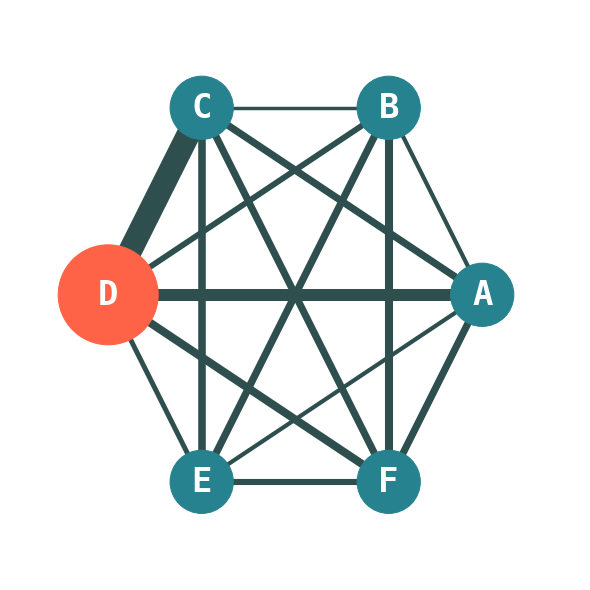

In [42]:
G=nx.from_numpy_matrix(SC6_tracts)
weights = 20.5*SC6[np.triu_indices(len(SC6),1)]
lab=listToDict(SC6_labels)
plt.figure(figsize=(8,8))
nx.draw_circular(G,labels=lab, width=weights**2, node_size=[4000,4000,4000,10000,4000,4000],font_color='w',edge_color='darkslategray',font_size=34,font_weight='bold',font_family='monospace',node_color=cln)
plt.axis('off')
axis = plt.gca()
axis.set_xlim([1.4*x for x in axis.get_xlim()])
axis.set_ylim([1.4*y for y in axis.get_ylim()])
plt.tight_layout()
path='/Users/giovanni/Documents/GitHub/fufo/data/Interim/Abhirup/Figures/Fig6/'
plt.savefig(path+'Fig6_Net.pdf',dpi=300,transparent=True)
plt.show()

# BACKUP

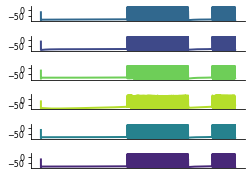

In [357]:
fig, ax = plt.subplots(nrows=6,ncols=1,figsize=(3.6,2.6))
for i in range(6):
    ax[i].plot(V_p[:,i],c=cln[i],linewidth=2)
    ax[i].spines["top"].set_visible(False)
    ax[i].spines["right"].set_visible(False)
    ax[i].set_xticks([])#np.asarray([0,7000]),np.asarray([0,70]))
    ax[i].tick_params(labelsize=8)
    #ax[i].set_yticks([])

plt.tight_layout()
#plt.savefig('Prova22.pdf',dpi=300)
plt.show()

In [298]:
7000*dt

70.0

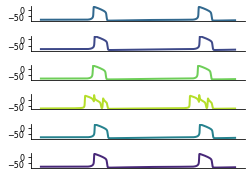

In [28]:
fig, ax = plt.subplots(nrows=6,ncols=1,figsize=(3.6,2.6))
for i in range(6):
    ax[i].plot(V_p[271000:275000,i],c=cln[i],linewidth=2)
    ax[i].spines["top"].set_visible(False)
    ax[i].spines["right"].set_visible(False)
    ax[i].set_xticks([])#np.asarray([0,7000]),np.asarray([0,70]))
    ax[i].tick_params(labelsize=8)
    #ax[i].set_yticks([])

plt.tight_layout()
#plt.savefig('Prova22.pdf',dpi=300)
plt.show()

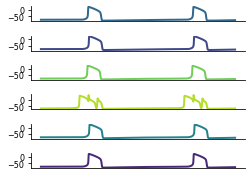

In [328]:
fig, ax = plt.subplots(nrows=6,ncols=1,figsize=(3.6,2.6))
for i in range(6):
    ax[i].plot(V_p[271000:275000,i],c=cln[i],linewidth=2)
    ax[i].spines["top"].set_visible(False)
    ax[i].spines["right"].set_visible(False)
    ax[i].set_xticks([])#np.asarray([0,7000]),np.asarray([0,70]))
    ax[i].tick_params(labelsize=8)
    #ax[i].set_yticks([])

plt.tight_layout()
plt.savefig('Prova22.pdf',dpi=300)
plt.show()

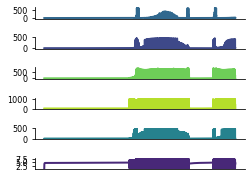

In [358]:
fig, ax = plt.subplots(nrows=6,ncols=1,figsize=(3.6,2.6))
for i in range(6):
    ax[i].plot(R_p[:,i],c=cln[i],linewidth=2)
    ax[i].spines["top"].set_visible(False)
    ax[i].spines["right"].set_visible(False)
    ax[i].set_xticks([])#np.asarray([0,7000]),np.asarray([0,70]))
    ax[i].tick_params(labelsize=8)
    #ax[i].set_yticks([])

plt.tight_layout()
#plt.savefig('Prova22.pdf',dpi=300)
plt.show()

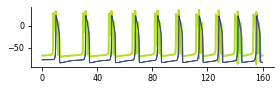

In [349]:
fig, ax = plt.subplots(figsize=(4.,1.35))
ax.plot(np.linspace(0,160,16000),V_p[271000:287000,3],c=cln[3],linewidth=2)
for i in range(6):
    ax.plot(np.linspace(0,160,16000),V_p[271000:287000,i],c=cln[i],linewidth=0.7)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_xticks([0,40,80,120,160])#np.asarray([0,7000]),np.asarray([0,70]))
    ax.tick_params(labelsize=8)
    #ax[i].set_yticks()

plt.tight_layout()
plt.savefig('Prova2.pdf',dpi=300)
plt.show()

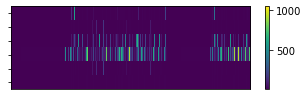

In [340]:
plt.figure(figsize=(4.5,1.5))
#plt.figure(figsize=(2.1,1.35))
plt.imshow(R_p[190000:,:].T,cmap='viridis',interpolation='nearest',aspect='auto')
plt.colorbar()
plt.xticks([])
plt.yticks([0,1,2,3,4,5],['','','','','',''])
plt.tight_layout()
plt.savefig('Prova3.pdf', transparent=True, format="PDF")
plt.show()

In [60]:
# 'E', 'K_bath', 'J', 'eta', 'Delta', 'G','c_minus','R_minus','c_plus','R_plus','Vstar'
E = 0
K_bath = 5.5
J=.01
eta=0
Delta=1
R_minus=0.5
R_plus=-0.5
c_minus=-50
c_plus=-20
Vstar = -31
G = 0.

THH = model_HH_ABH.InfiniteHH(
            E = np.r_[E],
            K_bath = np.asarray([15.5,15.5,15.5,15.5,15.5,15.5]),# np.asarray([K_bath,K_bath,K_bath,15.5,K_bath,K_bath]),
            J = np.r_[J],
            eta = np.r_[eta],
            Delta = np.r_[Delta],
            c_minus = np.r_[c_minus],
            R_minus = np.r_[R_minus],
            c_plus = np.r_[c_plus],
            R_plus = np.r_[R_plus],
            Vstar = np.r_[Vstar],
            G = np.r_[G])

In [61]:
## Initialise Integrator
dt = .01
heunint = integrators.HeunDeterministic(dt=dt)
# init_cond=np.zeros((1,5,6,1))
# for i in range(6):
#     init_cond[0,0,i,0]=0.1
#     init_cond[0,1,i,0]=-15
#     init_cond[0,2,i,0]=0.45
#     init_cond[0,3,i,0]=-5.
#     init_cond[0,4,i,0]=-16.
x_0=np.random.uniform(low=0.1, high=0.1, size=((1,1,nregions,1)))
V_0=np.random.uniform(low=-15., high=-15., size=((1,1,nregions,1)))
n_0=np.random.uniform(low=0.45, high=0.45, size=((1,1,nregions,1)))
DKi_0=np.random.uniform(low=-5., high=-5., size=((1,1,nregions,1)))
Kg_0=np.random.uniform(low=-16., high=-16., size=((1,1,nregions,1)))
init_cond=np.concatenate([x_0, V_0, n_0, DKi_0, Kg_0], axis=1)

In [62]:
# Initialise some Monitors with period in physical time.
#mon_tavg = monitors.TemporalAverage(period=Tperiod)
mon_raw = monitors.Raw()
what_to_watch = (mon_raw, ) #(mon_tavg, mon_bold) 

# Initialise Coupling
con_coupling = coupling.Scaling(a=np.array([G]))

# Initialise the Simulator.
sim = simulator.Simulator(model=THH,
                          connectivity=SC6_con,
                          conduction_speed=condspeed,
                          coupling=con_coupling,
                          integrator=heunint,
                          monitors= what_to_watch,
                          simulation_length=simlen) 
sim.initial_conditions = init_cond    
sim.configure()

,value
Type,Simulator
conduction_speed,inf
connectivity,Connectivity gid: 318bbbc1-d4d4-4f74-ac1b-a86f471021cb
coupling,Scaling gid: bec2e7e2-10dd-4c3b-b57f-9e212ad03975
gid,UUID('552b49d0-fe3f-4e8f-bd7e-59f3beed59c8')
"initial_conditions [min, median, max]","[-16, -5, 0.45]"
initial_conditions dtype,float64
initial_conditions shape,"(1, 5, 6, 1)"
integrator,HeunDeterministic gid: ca5c43b1-9bc4-462e-9edd-46534a0a239d
model,InfiniteHH gid: a94946a7-01df-4cec-93a1-d6dd30fe00e0


In [63]:

####################################################################
# RUN the SIMULATION 
####################################################################
#(raw_time, raw_data), (tavg_time, tavg_data) = sim.run()
(raw_time, raw_data),  = sim.run()

In [64]:
# Make the lists numpy.arrays for easier use.    
#TAVG=np.squeeze(np.array(tavg_data))   
RAW_p=np.squeeze(np.array(raw_data))   
R_p=(1000*R_minus/np.pi)*RAW[RAW_cut_in:,0,:]
V_p=RAW_p[RAW_cut_in:,1,:]

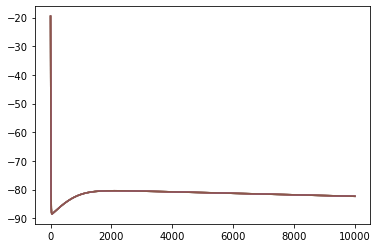

In [65]:
plt.plot(V_p)

/Users/giovanni/anaconda2/envs/p36workshop/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  if __name__ == '__main__':


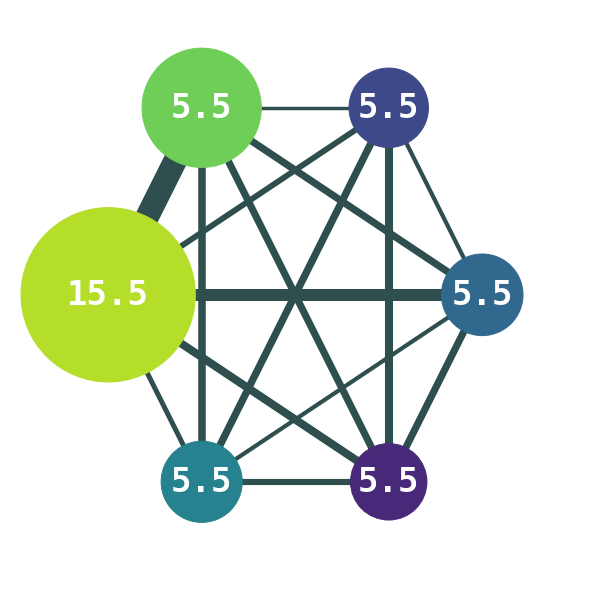

In [273]:
G=nx.from_numpy_matrix(SC6_tracts)
weights = 20.5*SC6[np.triu_indices(len(SC6),1)]
lab=listToDict(SC6_labels)
plt.figure(figsize=(8,8))
nx.draw_circular(G,labels=lab, width=weights**2, node_size=5000+Mean_R_p*200,font_color='w',edge_color='darkslategray',font_size=34,font_weight='bold',font_family='monospace',node_color=cln)
plt.axis('off')
axis = plt.gca()
axis.set_xlim([1.4*x for x in axis.get_xlim()])
axis.set_ylim([1.4*y for y in axis.get_ylim()])
plt.tight_layout()
plt.savefig('Prova')
plt.show()

In [19]:
# Make the lists numpy.arrays for easier use.    
#TAVG=np.squeeze(np.array(tavg_data))   
RAW=np.squeeze(np.array(raw_data))   

R=(1000*R_minus/np.pi)*RAW[:,0,:]
V=RAW[:,1,:]

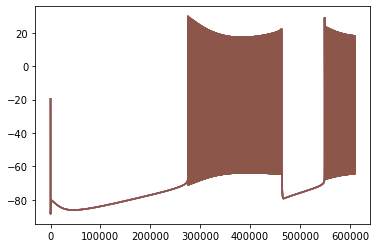

In [20]:
plt.plot(V)

In [62]:
def configure_single_node_sim(
    model,
    initial_conditions=None,
    sim_len=500,
    deterministic=True,
    noise_sigma=0.0,
    dt=0.01,
):
    """ Configures a single node simulation.

    Parameters
    sim_len        length [ms] of simulation
    deterministic  no noise if set to True (default True)
    dt             integration step (default 0.01)

    Returns:
    sim            configured simulator instance
    """

    conn = connectivity.Connectivity()
    conn.weights=np.zeros((2,2))
    conn.tract_lengths=np.zeros((2,2))
    conn.centres=np.zeros((2,3))
    conn.number_of_regions=2
    conn.region_labels = np.array(["A","ignore"])

    con_coupling = coupling.Scaling()

    if deterministic:
        integrator = integrators.RungeKutta4thOrderDeterministic(dt=dt)
    else:
        nsigma = noise_sigma
        hiss = noise.Additive(nsig=np.array([nsigma,nsigma*2]))
        integrator = integrators.HeunStochastic(dt=dt, noise=hiss)

    mntrs = [monitors.Raw()]

    if initial_conditions is not None:
        initial_conditions = np.stack(
                [initial_conditions,initial_conditions],
                axis=1
        )[np.newaxis,:,:, np.newaxis]

    sim = simulator.Simulator(model=model,
                              connectivity=conn,
                              coupling=con_coupling,
                              integrator=integrator,
                              monitors=mntrs,
                              simulation_length=sim_len)
    if initial_conditions is not None:
        sim.initial_conditions = initial_conditions

    sim.configure()

    return sim

In [63]:
sim = configure_single_node_sim(
    THH, 
    sim_len=20000,
    dt=0.1,
    initial_conditions=np.r_[0.1,-15.0, 0.45, -5, -16.0],
    deterministic=True
)

In [64]:
eqn_t = equations.Sinusoid()
eqn_t.parameters['amp'] = 0.
eqn_t.parameters['frequency'] = 3.14/12
stimulus = patterns.StimuliRegion(
    temporal=eqn_t,
    connectivity=sim.connectivity,
    weight=np.ones(sim.connectivity.number_of_regions)
)

sim.stimulus = stimulus
sim.configure();

In [65]:
(raw_time, raw_data), = sim.run()

In [66]:
x = raw_data[-60000:,0,0,0]
V = raw_data[-60000:,1,0,0]
n = raw_data[-60000:,2,0,0]
DKi = raw_data[-60000:,3,0,0]
Kg = raw_data[-60000:,4,0,0]

In [69]:
raw_data[-60000:,0,:,0].shape

(60000, 2)

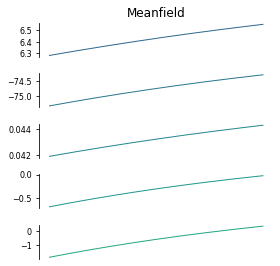

In [68]:
fig = plt.figure(figsize=(4,3.8))
ax1 = fig.add_subplot(511)
ax1.set_title('Meanfield')
ax1.plot((1000*R_minus/np.pi)*x,c=viridis(5),linewidth=1)
ax1.spines["top"].set_visible(False)
ax1.spines["bottom"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax1.set_xticks([])
ax1.tick_params(axis='both',labelsize=8)

ax1 = fig.add_subplot(512)
ax1.plot(V,c=viridis(6),linewidth=1)
ax1.spines["top"].set_visible(False)
ax1.spines["bottom"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax1.set_xticks([])
ax1.tick_params(axis='both',labelsize=8)

ax1 = fig.add_subplot(513)
ax1.plot(n,c=viridis(7),linewidth=1)
ax1.spines["top"].set_visible(False)
ax1.spines["bottom"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax1.set_xticks([])
ax1.tick_params(axis='both',labelsize=8)

ax1 = fig.add_subplot(514)
ax1.plot(DKi,c=viridis(8),linewidth=1)
ax1.spines["top"].set_visible(False)
ax1.spines["bottom"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax1.set_xticks([])
ax1.tick_params(axis='both',labelsize=8)

ax1 = fig.add_subplot(515)
ax1.plot(Kg,c=viridis(9),linewidth=1)
ax1.spines["top"].set_visible(False)
ax1.spines["bottom"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax1.set_xticks([])
ax1.tick_params(axis='both',labelsize=8)

plt.tight_layout()
#plt.savefig('Figures/J2Regime.pdf')
plt.show()

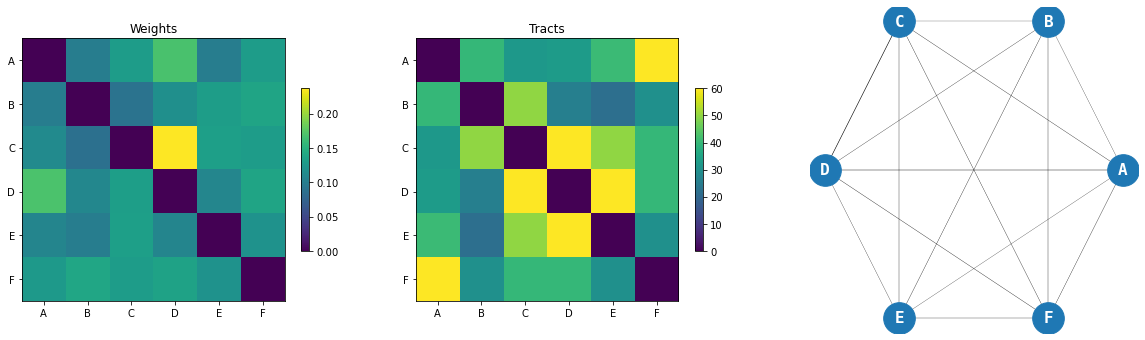

In [7]:
####################################################################
# IMPORT STRUCTURAL CONNECTIVITY
####################################################################
SC6_con = connectivity.Connectivity.from_file("/Users/giovanni/Desktop/Neuro/tvb_codes/connectivity/6x6full.zip")

nregions = len(SC6_con.weights)   
condspeed=np.infty #np.float(1.)
SC6_con.speed = np.array([condspeed])
np.fill_diagonal(SC6_con.weights, 0.)
#np.fill_diagonal(SC6_con.tract_lengths, 0.)

#normalization
SC6_con.configure()

SC6 = SC6_con.weights
SC6_tracts = SC6_con.tract_lengths
SC6_labels = ['A','B','C','D','E','F']

plt.figure(figsize=(20,6))
G=nx.from_numpy_matrix(SC6_tracts)
def listToDict(lst):
    op = { i : lst[i] for i in range(0, len(lst) ) }
    return op
lab=listToDict(SC6_labels)
weights = 2.5*SC6[np.triu_indices(len(SC6),1)]
nx.draw_circular(G,labels=lab, width=weights, node_size=1000,font_color='w',font_size=16,font_weight='bold',font_family='monospace')

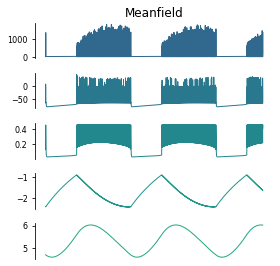

In [60]:
fig = plt.figure(figsize=(4,3.8))
ax1 = fig.add_subplot(511)
ax1.set_title('Meanfield')
ax1.plot((1000*R_minus/np.pi)*x,c=viridis(5),linewidth=1)
ax1.spines["top"].set_visible(False)
ax1.spines["bottom"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax1.set_xticks([])
ax1.tick_params(axis='both',labelsize=8)

ax1 = fig.add_subplot(512)
ax1.plot(V,c=viridis(6),linewidth=1)
ax1.spines["top"].set_visible(False)
ax1.spines["bottom"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax1.set_xticks([])
ax1.tick_params(axis='both',labelsize=8)

ax1 = fig.add_subplot(513)
ax1.plot(n,c=viridis(7),linewidth=1)
ax1.spines["top"].set_visible(False)
ax1.spines["bottom"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax1.set_xticks([])
ax1.tick_params(axis='both',labelsize=8)

ax1 = fig.add_subplot(514)
ax1.plot(DKi,c=viridis(8),linewidth=1)
ax1.spines["top"].set_visible(False)
ax1.spines["bottom"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax1.set_xticks([])
ax1.tick_params(axis='both',labelsize=8)

ax1 = fig.add_subplot(515)
ax1.plot(Kg,c=viridis(9),linewidth=1)
ax1.spines["top"].set_visible(False)
ax1.spines["bottom"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax1.set_xticks([])
ax1.tick_params(axis='both',labelsize=8)

plt.tight_layout()
#plt.savefig('Figures/J2Regime.pdf')
plt.show()

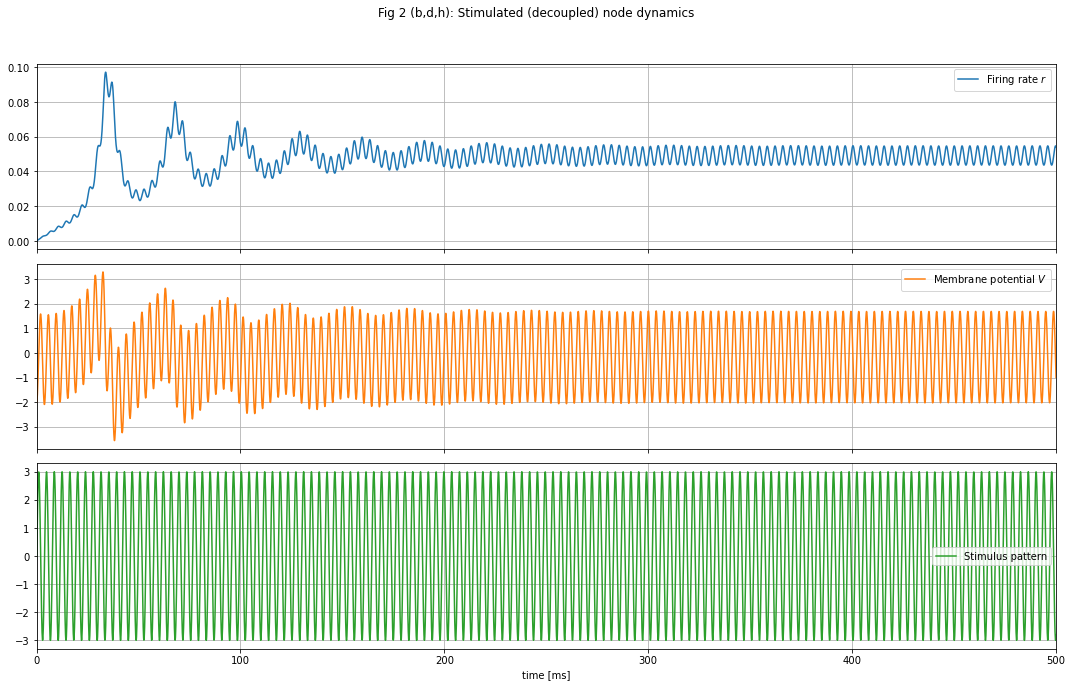

In [56]:
fig, axs = plt.subplots(nrows=3, sharex=True, figsize=(15,10))
pattern = sim.stimulus.temporal_pattern[0]

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

for i, (var, label) in enumerate([(r,'Firing rate $r$'), (V,'Membrane potential $V$'), (pattern,'Stimulus pattern')]):
    ax = axs[i]
    ax.plot(raw_time, var, label=label, c=colors[i])
    ax.set_xlim((0,sim.simulation_length))
    ax.legend()
    ax.grid()
axs[-1].set_xlabel('time [ms]')

fig.suptitle('Fig 2 (b,d,h): Stimulated (decoupled) node dynamics')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

In [10]:
####################################################################
# INITIALIZE THE SIMULATOR
####################################################################
#T2d = models.MontbrioPazoRoxin(variables_of_interest=('r','V')) 
#eta=np.array([-4.6]), J=np.array([14.5]), Delta=np.array([0.7]),
#cv=np.array([1.]), cr=np.array([0.]) ,
G=np.float(2.)
nsigma=np.float(0.01)

dt = 0.05
cut_in=100
simlen=600e1+cut_in

#BOLD, TAVG period
Bperiod=2000
Tperiod=1.

B_len=int(simlen/Bperiod)
T_len=int(simlen/Tperiod)
R_len=int(simlen/dt)

B_cut_in=cut_in/Bperiod
TAVG_cut_in=int(cut_in/Tperiod)
RAW_cut_in=int(cut_in/Tperiod)
t_RAW=np.arange(0, simlen, dt)

# Initialise some Monitors with period in physical time.
mon_bold = monitors.Bold(period=Bperiod)
#mon_tavg = monitors.TemporalAverage(period=Tperiod)
mon_raw = monitors.Raw()
what_to_watch = (mon_raw, mon_bold) 

#############################################
#Set initial conditions for V and r variables
r_0=np.random.uniform(low=0., high=2., size=((1,1,nregions,1)))
V_0=np.random.uniform(low=-2., high=1.5, size=((1,1,nregions,1)))
init_cond=np.concatenate([r_0, V_0], axis=1)

# Initialise Integrator.
#hiss = noise.Additive(nsig=np.array([nsigma,nsigma*2]))
#heunint = integrators.HeunDeterministic(dt=dt)#, noise=hiss)
hiss = noise.Additive(nsig=np.array([0.1*nsigma,nsigma,]))
heunint = integrators.HeunStochastic(dt=dt, noise=hiss)
# Initialise Coupling
con_coupling = coupling.Scaling(a=np.array([G]))

#Stimulation
T2d.stvar=np.r_[1] # stimulate the membrane potential

# configure stimulus spatial pattern (we only stimulate region 0)
weighting = numpy.zeros((6, ))
weighting[[0]] = 0.
# configure stimulus temporal pattern

#SINUSOID
eqn_t = equations.Sinusoid()
eqn_t.parameters['amp'] = 0.1
eqn_t.parameters['frequency'] = 1/1000.

stimulus = patterns.StimuliRegion(
    temporal=eqn_t,
    connectivity=SC6_con,
    weight=weighting)
#Configure space and time
stimulus.configure_space()
stimulus.configure_time(numpy.arange(0., simlen, dt))


# Initialise the Simulator.
sim = simulator.Simulator(model=T2d,
                          connectivity=SC6_con,
                          conduction_speed=condspeed,
                          coupling=con_coupling,
                          integrator=heunint,
                          monitors= what_to_watch,
                          simulation_length=simlen) 
sim.initial_conditions = init_cond    
sim.stimulus=stimulus
sim.configure()

,value
Type,Simulator
conduction_speed,inf
connectivity,Connectivity gid: a2d3e815-186e-4c05-81fd-e9374265a8dc
coupling,Scaling gid: 76f90d86-d313-4da6-b278-5d20020e3da0
gid,UUID('a849acbd-8f3e-44b7-8142-b4ca675ec785')
"initial_conditions [min, median, max]","[-1.99841, 0.539488, 1.99499]"
initial_conditions dtype,float64
initial_conditions shape,"(1, 2, 148, 1)"
integrator,HeunStochastic gid: 15716525-7d1b-474b-8d44-dde2767d7326
model,MontbrioPazoRoxin gid: a7be5c46-99cb-403b-b43b-da187706e407


In [66]:
simlen

100

In [11]:
####################################################################
# RUN the SIMULATION 
####################################################################
(raw_time, raw_data), (bold_time, bold_data) = sim.run()

# Make the lists numpy.arrays for easier use.    
B=np.array(bold_data)
#TAVG=np.squeeze(np.array(tavg_data))   
RAW=np.squeeze(np.array(raw_data))   

#exclude the corresponding points in the BOLD signal
B_cut_in=int(cut_in/Bperiod)
#TAVG_cut_in=int(cut_in/Tperiod)
RAW_cut_in=int(cut_in/dt)

# Remove transcient time
B = B[B_cut_in:, 1, :, :]
BOLD= np.squeeze(B)
#r=TAVG[TAVG_cut_in:,0,:]
#V=TAVG[TAVG_cut_in:,1,:]
r=RAW[RAW_cut_in:,0,:]
V=RAW[RAW_cut_in:,1,:]
t_RAW=t_RAW[RAW_cut_in:]

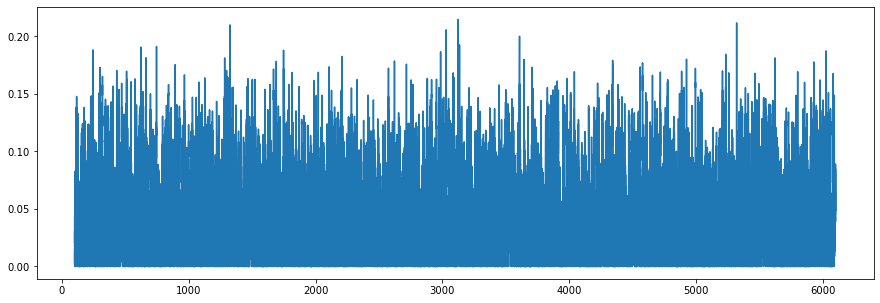

In [14]:
plt.figure(figsize=(15,5))
#pattern = sim.stimulus.temporal_pattern[0][RAW_cut_in:]
plt.plot(t_RAW,r[:,0], label='Firing Rate')

#plt.plot(t_RAW,pattern, label='Stimulus pattern')
#plt.title('Stimulated (decoupled) node dynamics');plt.xlabel('time(ms)');plt.legend();plt.grid();plt.show

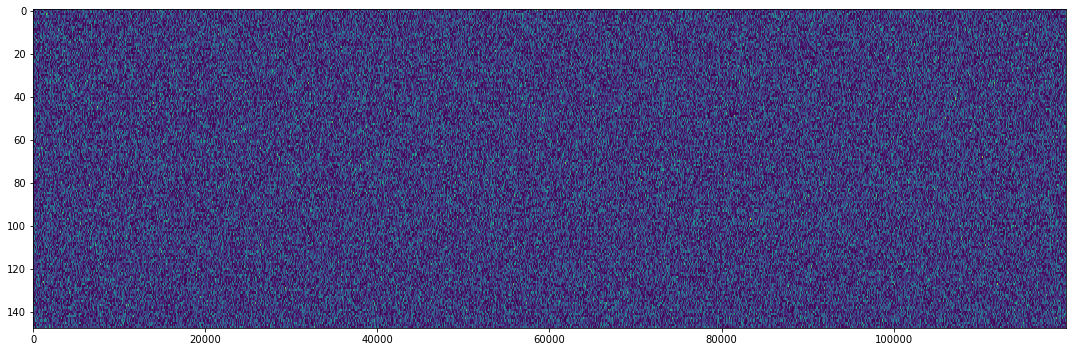

In [15]:
plt.figure(figsize=(15,5))
plt.imshow(r.T,aspect='auto',interpolation='none')
plt.tight_layout()
plt.show()

In [ ]:
plt.imshow(np.corrcoef(r.T))